### import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow.keras as keras
from tensorflow.keras.utils import load_img, img_to_array, array_to_img, to_categorical
from tensorflow.keras.preprocessing import image
import tensorflow as tf

In [2]:
def shuffle_directories(train_input_dir, filt_type, seed, shuffle, chunkstart, chunkend, is_it_label_address):
    '''
    train_input_img_paths = [os.path.join(train_input_dir, fname) 
         for fname in os.listdir(train_input_dir) 
             if fname.endswith(filt_type)]
    '''
    pd_array = pd.read_csv(train_input_dir)
    train_input_img_paths = pd_array.iloc[:, 0].tolist()

    def modify_address(x):
        x1 = x.split("v2.0")
        x2 = x1[1].split("labels")
        x3 = x2[1].split("png")
        y = x1[0] + 'images' + x3[0] + 'jpg'
        return y

    if (is_it_label_address==False):
        train_input_img_paths = [modify_address(x) for x in train_input_img_paths]
    else:
        pass
        

    if shuffle == True:
        random.Random(seed).shuffle(train_input_img_paths)
    else:
        pass
    return train_input_img_paths[chunkstart : chunkend]

### function that generates numpy array of images from the directory. The function also reshapes the image to the desired dimension

In [3]:
def path_to_raw_data(path, img_breadth, img_length ):
    return img_to_array(load_img(path, target_size=(img_breadth, img_length) ))


def get_numpy_array_of_all_images_in_folder(train_input_img_paths, num_images, img_breadth, img_length):
    train_input_imgs = np.zeros( (num_images, img_breadth, img_length, 3), dtype='float32')
    for i in range(num_images):
        train_input_imgs[i] = path_to_raw_data(train_input_img_paths[i],img_breadth, img_length)
    return train_input_imgs

### function that generates numpy array of targets from directory

In [4]:
def convert_color_to_mask_class (x, img_breadth, img_length, labelA, labelB ):   
    y = np.zeros((img_breadth, img_length, 1))
    x = tf.convert_to_tensor(x)
    y[:,:,0] = tf.where(  ((x[:,:,0]==labelA[0])   & (x[:,:,1]==labelA[1])   & (x[:,:,2]==labelA[2]))  , 1 , 
               tf.where(  ((x[:,:,0]==labelB[0])   & (x[:,:,1]==labelB[1])   & (x[:,:,2]==labelB[2]))  , 1 ,                                                                                 
                   0 ))
    return y




def path_to_target (path, img_breadth, img_length, labelA, labelB):
    mask = img_to_array(load_img(path, target_size=(img_breadth, img_length)  ))
    mask = convert_color_to_mask_class (mask, img_breadth, img_length, labelA, labelB)
    return mask

def get_numpy_array_of_all_targets_in_folder(train_target_paths, num_images, img_breadth, img_length, labelA, labelB):
    train_targets_updated = np.zeros( (num_images, img_breadth, img_length, 1), dtype='int')
    for i in range(num_images):
        train_targets_updated[i] = path_to_target(train_target_paths[i], img_breadth, img_length, labelA, labelB)
    return train_targets_updated

### split image into train, dev, test

In [5]:
def train_val_test_split(train_input_imgs, train_targets_updated, train_fraction, val_fraction, num_images ):
    test_fraction = 1 - train_fraction - val_fraction
    train_length = int (num_images * train_fraction)
    val_length = int (num_images * val_fraction)
    test_length = num_images - train_length - val_length
    val_input_imgs = train_input_imgs[ : val_length]
    val_targets = train_targets_updated[ : val_length]
    test_input_imgs = train_input_imgs[val_length : (val_length + test_length)]
    test_targets = train_targets_updated[val_length : (val_length + test_length)]
    train_input_imgs = train_input_imgs[(val_length + test_length) : ]
    train_targets = train_targets_updated[(val_length + test_length) : ]
    return [train_input_imgs, train_targets, val_input_imgs, val_targets,test_input_imgs, test_targets]
    

In [6]:
def get_train_val_test_data(input_path, target_path, input_filter_type, target_filter_type, img_length, img_breadth, train_fraction, val_fraction, seed, shuffle, chunkstart, chunkend, labelA, labelB):
    train_input_img_paths = shuffle_directories(input_path, input_filter_type, seed, shuffle, chunkstart, chunkend, is_it_label_address = False )
    train_target_paths = shuffle_directories(target_path, target_filter_type, seed, shuffle, chunkstart, chunkend, is_it_label_address = True )
    img_length = img_length
    img_breadth = img_breadth
    num_images = len(train_target_paths)
    train_targets_updated = get_numpy_array_of_all_targets_in_folder(train_target_paths, num_images, img_breadth, img_length, labelA, labelB)
    train_input_imgs = get_numpy_array_of_all_images_in_folder(train_input_img_paths, num_images, img_breadth, img_length)
    return train_val_test_split(train_input_imgs, train_targets_updated, train_fraction, val_fraction,  num_images )

In [7]:
def get_batch_of_image_and_label(input_path, target_path, input_filter_type, target_filter_type, img_length, img_breadth, chunkstart, chunkend, labelA, labelB, seed=50, shuffle=False):
    train_input_img_paths = shuffle_directories(input_path, input_filter_type, seed, shuffle, chunkstart, chunkend, is_it_label_address=False )
    train_target_paths = shuffle_directories(target_path, target_filter_type, seed, shuffle, chunkstart, chunkend, is_it_label_address=True  )
    img_length = img_length
    img_breadth = img_breadth
    num_images = len(train_target_paths)
    train_targets_updated = get_numpy_array_of_all_targets_in_folder(train_target_paths, num_images, img_breadth, img_length, labelA, labelB)
    train_input_imgs = get_numpy_array_of_all_images_in_folder(train_input_img_paths, num_images, img_breadth, img_length)
    return [train_input_imgs, train_targets_updated]
    

### test functions

In [8]:
img_length = 512
img_breadth = 256
input_path = 'train_address.csv'
target_path = 'train_address.csv'
input_filter_type =".jpg"
target_filter_type =".png"

In [9]:
pd_array = pd.read_csv(input_path)

In [10]:
[train_input_imgs, train_targets, val_input_imgs, val_targets,test_input_imgs, test_targets] = get_train_val_test_data( input_path = input_path,
                                                                                                                        target_path = target_path, 
                                                                                                                        input_filter_type = input_filter_type, 
                                                                                                                        target_filter_type = target_filter_type, 
                                                                                                                        img_length = img_length, 
                                                                                                                        img_breadth = img_breadth, 
                                                                                                                        train_fraction = 0.4,
                                                                                                                        val_fraction = 0.4, 
                                                                                                                        seed = 1337, 
                                                                                                                        shuffle = False,
                                                                                                                        chunkstart=0,
                                                                                                                        chunkend=40,
                                                                                                                        labelA = [210, 60, 60], 
                                                                                                                        labelB = [250, 170, 35],
                                                                                                                        )

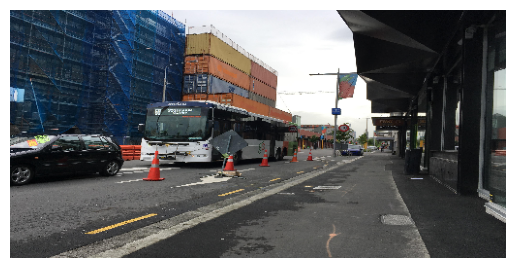

In [11]:
i=3
val_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(val_image))

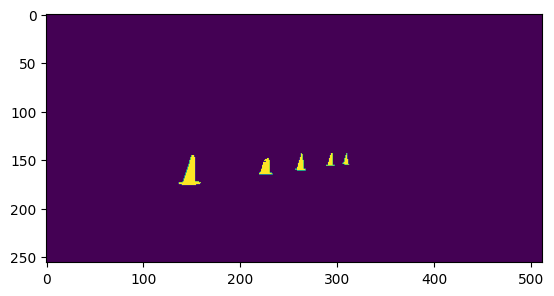

In [12]:
#plt.imshow( reverse_one_hot( test_targets[i], img_breadth=256, img_length=512) )
plt.imshow(val_targets[i]) 

In [13]:
len(train_input_imgs)

16

In [14]:
len(val_targets)

16

In [15]:
len(test_input_imgs)

8

##   ***************************

In [16]:
[x,y] = get_batch_of_image_and_label(input_path=input_path, 
                             target_path=target_path, 
                             input_filter_type = input_filter_type, 
                             target_filter_type = target_filter_type,
                             img_length=img_length, 
                             img_breadth=img_breadth, 
                             chunkstart=0, 
                             chunkend=20, 
                             seed=50, 
                             shuffle=False,
                             labelA = [210, 60, 60], 
                             labelB = [250, 170, 35])

In [17]:
len(x)

20

In [18]:
len(y)

20

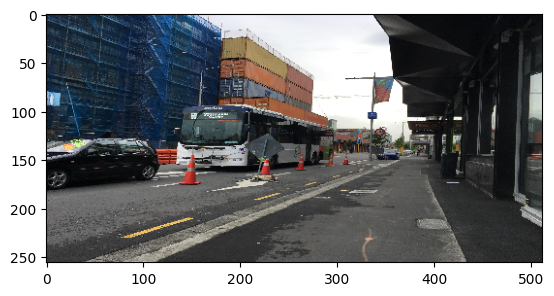

In [19]:
plt.imshow(array_to_img(x[i]))

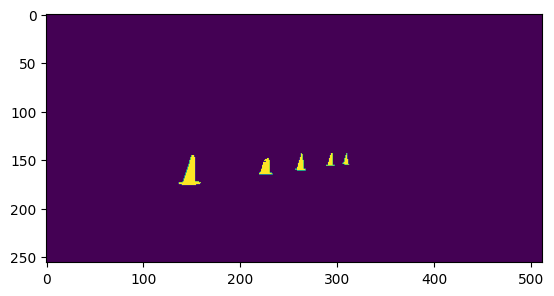

In [20]:
plt.imshow(  y[i] )

## ******************** class distribution *******************************************

In [21]:
img = val_targets[i]
img_adjust = img.reshape((np.size(img,0)*np.size(img,1),1))
img_pandas = pd.DataFrame(img_adjust, columns=['a'])
img_pandas['a'].value_counts()

a
0    130465
1       607
Name: count, dtype: int64

In [22]:
img_pandas['a'].value_counts()[0]/img_pandas['a'].value_counts()[1]

214.9341021416804